In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

result_df = pd.read_csv("../extra//randomseed/randomseed_adamson.csv", index_col=0)
result_df["1-PCC"] = 1 - result_df["Pearson"]
result_df.drop(columns=["Pearson"], inplace=True)

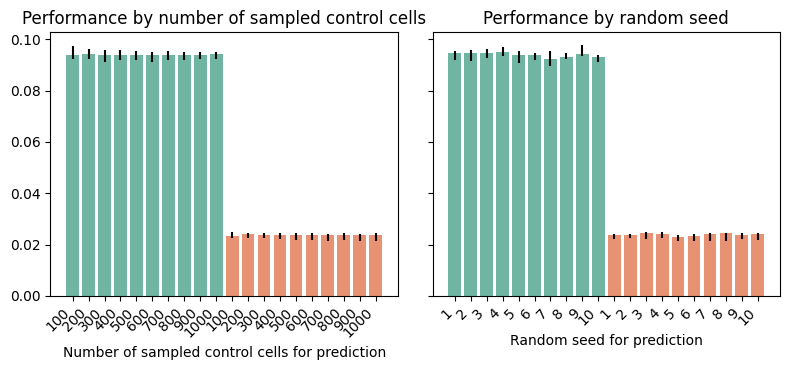

In [3]:
# === 2. Boostrap CI ===
def bootstrap_ci(data, n_bootstrap=1000, alpha=0.5):
    medians = [np.median(np.random.choice(data, size=len(data), replace=True)) for _ in range(n_bootstrap)]
    lower = np.percentile(medians, alpha / 2 * 100)
    upper = np.percentile(medians, (1 - alpha / 2) * 100)
    return lower, upper

# === 3. Compute CI by group ===
def compute_ci_by_group(df, group_col):
    rows = []
    grouped = df.groupby(group_col)
    for name, group in grouped:
        for metric in ["NormMSE", "1-PCC"]:
            median = group[metric].median()
            ci_lower, ci_upper = bootstrap_ci(group[metric])
            rows.append({
                "group": name,
                "metric": metric,
                "median": median,
                "ci_lower": ci_lower,
                "ci_upper": ci_upper
            })
    return pd.DataFrame(rows)

df_npred_ci = compute_ci_by_group(result_df, "n_pred")
df_seed_ci = compute_ci_by_group(result_df, "seed")

# === 4. Plot preparation ===
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

bar_width = 0.8
color_mse = '#70b5a1'
color_pcc = '#e79272'

# === 5. Left plot: Group by n_pred ===
metrics = ["NormMSE", "1-PCC"]
group_vals = sorted(df_npred_ci["group"].unique())
x = np.arange(len(group_vals) * len(metrics))
xtick_labels = []
bar_vals = []
yerr_lower = []
yerr_upper = []
bar_colors = []

for i, metric in enumerate(metrics):
    sub_df = df_npred_ci[df_npred_ci["metric"] == metric].sort_values("group")
    bar_vals.extend(sub_df["median"].values)
    yerr_lower.extend(sub_df["median"].values - sub_df["ci_lower"].values)
    yerr_upper.extend(sub_df["ci_upper"].values - sub_df["median"].values)
    color = color_mse if metric == "NormMSE" else color_pcc
    bar_colors.extend([color] * len(sub_df))
    xtick_labels.extend(sub_df["group"])

yerr_array = np.array([yerr_lower, yerr_upper])

axes[0].bar(x, bar_vals, yerr=yerr_array, capsize=0, width=bar_width, color=bar_colors)
axes[0].set_xticks(x)
axes[0].set_xticklabels(xtick_labels, rotation=45, ha="right")
axes[0].set_xlabel("Number of sampled control cells for prediction")
axes[0].set_title("Performance by number of sampled control cells")
axes[0].set_ylabel("")

# === 6. Right plot: Group by seed ===
group_vals = sorted(df_seed_ci["group"].unique())
x = np.arange(len(group_vals) * len(metrics))
xtick_labels = []
bar_vals = []
yerr_lower = []
yerr_upper = []
bar_colors = []

for i, metric in enumerate(metrics):
    sub_df = df_seed_ci[df_seed_ci["metric"] == metric].sort_values("group")
    bar_vals.extend(sub_df["median"].values)
    yerr_lower.extend(sub_df["median"].values - sub_df["ci_lower"].values)
    yerr_upper.extend(sub_df["ci_upper"].values - sub_df["median"].values)
    color = color_mse if metric == "NormMSE" else color_pcc
    bar_colors.extend([color] * len(sub_df))
    xtick_labels.extend(sub_df["group"])

yerr_array = np.array([yerr_lower, yerr_upper])

axes[1].bar(x, bar_vals, yerr=yerr_array, capsize=0, width=bar_width, color=bar_colors)
axes[1].set_xticks(x)
axes[1].set_xticklabels(xtick_labels, rotation=45, ha="right")
axes[1].set_xlabel("Random seed for prediction")
axes[1].set_title("Performance by random seed")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(wspace=0.1)
plt.show()